## **Logistic Regression Model**

In [218]:
import numpy as np
import pandas as pd

import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import specgram

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [14]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('Emotions/input/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [15]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
11686,Emotions/input/Sad\a01.wav,sad.wav
6969,Emotions/input/Happy\1038_IEO_HAP_HI.wav,happy.wav
10429,Emotions/input/Sad\1002_DFA_SAD_XX.wav,sad.wav
2657,Emotions/input/Disgusted\1022_IWL_DIS_XX.wav,disgusted.wav
7594,Emotions/input/Happy\1082_TAI_HAP_XX.wav,happy.wav
6931,Emotions/input/Happy\1035_ITH_HAP_XX.wav,happy.wav
8311,Emotions/input/Neutral\03-01-01-01-02-01-23.wav,neutral.wav
12380,Emotions/input/Suprised\03-01-08-02-02-02-07.wav,suprised.wav
10444,Emotions/input/Sad\1003_IEO_SAD_HI.wav,sad.wav
10618,Emotions/input/Sad\1015_MTI_SAD_XX.wav,sad.wav


In [16]:
# Labelencoder para convertir las clases a etiquetas númericas
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'label'.
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [17]:
data.head()

,speech,label
0,Emotions/input/Angry\03-01-05-01-01-01-01.wav,0
1,Emotions/input/Angry\03-01-05-01-01-01-02.wav,0
2,Emotions/input/Angry\03-01-05-01-01-01-03.wav,0
3,Emotions/input/Angry\03-01-05-01-01-01-04.wav,0
4,Emotions/input/Angry\03-01-05-01-01-01-05.wav,0


In [18]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    
def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    Audio(path)

In [19]:
# Clases de emociones en el datset
data['label'].unique().tolist()

[0, 1, 2, 3, 4, 5, 6]

In [21]:
#for i in data['label'].unique().tolist(): # ver uno de cada sentimiento
#    ana_emotion(i,data)

In [22]:
# Coeficientes Septrales - Transformación del audio en una serie de parametros que representan de forma compacta el sonido
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [85]:
mfcc

0        [-492.3691, 56.3634, -9.584242, 18.014067, -3....
1        [-527.9743, 54.69438, -14.746857, 8.957756, -9...
2        [-557.1632, 79.16915, -1.0876601, 23.747974, 1...
3        [-523.06934, 43.876232, -14.765749, 5.9150915,...
4        [-473.48077, 75.53822, -19.603502, 10.48258, 4...
                               ...                        
12793    [-376.5839, 63.959797, -3.0598657, 11.498796, ...
12794    [-355.02838, 87.61324, -22.081991, 2.3526459, ...
12795    [-345.9045, 62.633904, 2.1816177, 3.6597912, -...
12796    [-334.6705, 80.249825, -32.716793, 3.8717275, ...
12797    [-376.12756, 63.290413, -6.507844, 16.757235, ...
Name: speech, Length: 12798, dtype: object

In [24]:
print(f'Cantidad de Registros de Audio: {mfcc.shape}')

Cantidad de Registros de Audio: (12798,)


In [100]:
import numpy as np
X = np.asarray(mfcc.to_list())
y = np.asarray(data['label'])


In [101]:
X

array([[-4.9236911e+02,  5.6363400e+01, -9.5842419e+00, ...,
        -3.0204347e-01, -4.6737876e+00, -1.5017204e+00],
       [-5.2797430e+02,  5.4694382e+01, -1.4746857e+01, ...,
         1.8938642e+00,  4.9922979e-01,  1.0369350e+00],
       [-5.5716321e+02,  7.9169151e+01, -1.0876601e+00, ...,
        -2.7364600e+00, -6.0165200e+00, -1.7894462e+00],
       ...,
       [-3.4590451e+02,  6.2633904e+01,  2.1816177e+00, ...,
         3.1764922e+00, -1.4632556e-01,  2.7278659e+00],
       [-3.3467050e+02,  8.0249825e+01, -3.2716793e+01, ...,
         6.3607258e-01,  1.6670487e+00,  3.2698379e+00],
       [-3.7612756e+02,  6.3290413e+01, -6.5078440e+00, ...,
         5.6975141e+00,  3.1801860e+00,  2.4653611e+00]], dtype=float32)

In [102]:
y

array([0, 0, 0, ..., 6, 6, 6])

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [113]:
#Estandarizar
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [128]:
print(f'Dimensiones mfcc:{X.shape}')
print(f'Dimensiones label:{y.shape}')

Dimensiones mfcc:(12798, 40)
Dimensiones label:(12798,)


In [219]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":['l1','l2','none']}# l1 lasso l2 ridge and none

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.47959533980113916


In [164]:
logistic_model_LR = LogisticRegression(C=10,penalty="l2")
logistic_model_LR.fit(X_train,y_train)
print("score",logistic_model_LR.score(X_test,y_test))

score 0.46015625


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [220]:
metrics = ['accuracy']
cv_results_LR = cross_validate(logistic_model_LR, X_train, y_train, scoring=metrics, cv = 10)

In [221]:
'''
Resultados obtenidos aplicando validación cruzada(cross-validation) al modelo
LogisticRegression
'''
cv_results_LR

{'fit_time': array([0.43203354, 0.42099881, 0.45600581, 0.35799766, 0.35200024,
        0.36499977, 0.36351085, 0.36099982, 0.36253047, 0.41758633]),
 'score_time': array([0.0010016 , 0.00099993, 0.00099707, 0.        , 0.0010004 ,
        0.00100017, 0.00099993, 0.00100088, 0.00067687, 0.00099826]),
 'test_accuracy': array([0.48090278, 0.48350694, 0.48611111, 0.46788194, 0.46006944,
        0.49652778, 0.49913194, 0.48350694, 0.47002606, 0.46828844])}

In [222]:
#Predecir sobre el train y sobre el test
y_pred_train = logistic_model_LR.predict(X_train)
y_pred_test = logistic_model_LR.predict(X_test)

In [223]:
#Calcule el accuracy. Graficar la matriz de confusión.
#Calcule el accuracy. 

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'Acc en el conjunto de entrenamiento: {accuracy_train}')
print(f'Acc en el conjunto de test: {accuracy_test}')

Acc en el conjunto de entrenamiento: 0.4877582913700295
Acc en el conjunto de test: 0.46015625


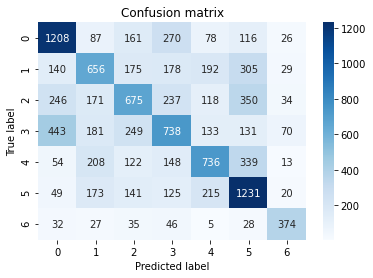

In [224]:
from sklearn.metrics import confusion_matrix
cm2_train = confusion_matrix(y_train, y_pred_train)
cm2_test = confusion_matrix(y_test, y_pred_test)

#Graficar la matriz de confusión.
import seaborn as sns
sns.heatmap(cm2_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()  

In [225]:
report_test2 = classification_report(y_test ,y_pred_test.round())  
print(report_test2)

report_train2 = classification_report(y_train ,y_pred_train.round())  
print(report_train2)

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       221
           1       0.35      0.34      0.34       188
           2       0.47      0.38      0.42       216
           3       0.41      0.34      0.37       222
           4       0.48      0.45      0.46       175
           5       0.44      0.60      0.51       213
           6       0.63      0.76      0.69        45

    accuracy                           0.46      1280
   macro avg       0.48      0.49      0.48      1280
weighted avg       0.46      0.46      0.46      1280

              precision    recall  f1-score   support

           0       0.56      0.62      0.59      1946
           1       0.44      0.39      0.41      1675
           2       0.43      0.37      0.40      1831
           3       0.42      0.38      0.40      1945
           4       0.50      0.45      0.48      1620
           5       0.49      0.63      0.55      1954
           6       0.66 

In [226]:
from sklearn.metrics import roc_curve, roc_auc_score
#ROC
r_probs = [0 for _ in range(len(y_test))] # un vector de ceros para ver el peor de los casos 
y_pred_LR = logistic_model_LR.predict(X_test) # Predicciones de regresión logística

In [227]:
#Area bajo la curva (AUC)
#r_auc = roc_auc_score(y_test, r_probs, multi_class='ovr') 
#lr_LR_auc = roc_auc_score(y_test, y_pred_LR, multi_class='ovr') 

#r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
#lr_LR_fpr, lr_LR_tpr, _ = roc_curve(y_test, y_pred_LR)

In [209]:
#plt.plot(lr_LR_fpr, lr_LR_tpr, marker='.', label='LogisticRegression (AUROC = %0.3f)' % lr_LR_auc)

# Title
#plt.title('ROC Plot')
# Axis labels
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
# Show legend
#plt.legend() # 
# Show plot
#plt.show()